In [1]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist

from IPython.display import clear_output
import matplotlib.pyplot as plt


use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# Replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done, t):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done, t)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, t = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done, t
    
    def __len__(self):
        return len(self.buffer)

# Value Network (Critic)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# Soft Q Network (Critic)
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + 1, hidden_size) # num_inputs + action
        self.linear2 = nn.Linear(hidden_size, 1)
        self.linear3 = nn.Linear(num_inputs + 1, hidden_size) # num_inputs + action
        self.linear4 = nn.Linear(hidden_size, 1)
        
        self.linear2.weight.data.uniform_(-init_w, init_w)
        self.linear2.bias.data.uniform_(-init_w, init_w)
        
        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        x1 = F.relu(self.linear1(x))
        x1 = self.linear2(x1)
        
        x2 = F.relu(self.linear3(x))
        x2 = self.linear4(x2)

        return x1, x2

# PolicyNetwork (Actor)
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3): #log_std_max=2
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size) # nn.Linear(hidden_size, num_actions)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        self.softplus = nn.Softplus()
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
#         x = F.relu(self.linear2(x))
        probs = F.softmax(self.linear3(x), dim=-1)
        
        return probs # policy
    
    def sample(self, state):
        probs = self.forward(state)
        action = dist.Categorical(probs).sample().unsqueeze(1)
        
        mask = torch.zeros_like(probs).scatter_(1, action, 1).to(torch.uint8) # one-hot
        sampled_prob = torch.masked_select(probs, mask).unsqueeze(1)
        
        log_prob = torch.log(sampled_prob)
        
        return probs, action.to(torch.float32), log_prob
        
    def evaluate(self, state):
        probs = self.forward(state)
        action = torch.argmax(probs, dim=1)
        return action
    

def soft_q_update(batch_size, gamma=0.99, alpha=0.25, soft_tau= 5e-3): # alpha :temperature for entropy

    state, action, reward, next_state, done, t = replay_buffer.sample(batch_size)

    state      = torch.Tensor(state).to(device)
    next_state = torch.Tensor(next_state).to(device)
    action     = torch.Tensor(action).unsqueeze(1).to(device)
    reward     = torch.Tensor(reward).unsqueeze(1).to(device)
    done       = torch.Tensor(np.float32(done)).unsqueeze(1).to(device)
    t          = torch.Tensor(t).unsqueeze(1).to(device)
 
    with torch.no_grad():
        next_prob, next_action, next_log_prob = policy_net.sample(next_state)
        q_1_next_target, q_2_next_target = target_q_net(next_state, next_action)
        min_q_next_target = torch.min(q_1_next_target, q_2_next_target) - alpha * next_log_prob
        next_q_value = reward + (1-done) * gamma * (min_q_next_target)

    expected_q_1, expected_q_2 = q_net(state, action)
    # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
    q_1_loss = F.mse_loss(expected_q_1, next_q_value)
    q_2_loss = F.mse_loss(expected_q_2, next_q_value)
    
    probs, new_action, log_prob = policy_net.sample(state)
    
    q1_new, q2_new = q_net(state, new_action)
    min_q_new = torch.min(q1_new, q2_new)
    
    # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
    policy_loss = ((alpha * log_prob) - min_q_new).mean()
    
    q_net_optimizer.zero_grad()
    q_1_loss.backward()
    q_net_optimizer.step()
    
    q_net_optimizer.zero_grad()
    q_2_loss.backward()
    q_net_optimizer.step()
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    # update target network
    for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)
    
    return [q_1_loss.item(), q_2_loss.item(), policy_loss.item()]

In [21]:
replay_buffer_size = 100000 # 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

def getaction(policy_net, state, mode): # fcn which returns categorical action 
    inventory = state[1]
    
    state = torch.Tensor(state).to(device)
    probs = policy_net(state) # q : categorical action probability

    if inventory > 0.0:
        # If there is a buying share in inventory, SELL or HOLD (additional buying is prohibited)
        if probs[SELL] > probs[HOLD]:
            return SELL
        else:
            return HOLD

    elif inventory < 0.0:
        # If there is a selling share in inventory, BUY or HOLD (additional selling is prohibited)
        if probs[BUY] > probs[HOLD]:
            return BUY
        else:
            return HOLD
    else:
        # If there are no share in inventory, BUY, SELL, or HOLD

        if mode == 'train':
            m = dist.Categorical(probs)
            action = m.sample()
            return int(action)
        
        
        elif mode == 'eval':
            action = torch.argmax(probs, dim=-1)
            return action.item()
        
        
def scenario(policy_net, data):
    
    policy_net.train()
    
    # initial setting
    spread = data['dPrice'][0]
    inventory = 0

    start = np.random.randint(low=1, high=1000) # arbitrary start point for iterative training
    step = np.random.randint(low=100, high=500) # arbitrary step, because delta t(Tick) is very small

    for t in range(start, len(data), step):
        
        spread = data['dPrice'][t]
        state = [spread, inventory]
        action = getaction(policy_net, state, mode='train')
    
        done = False
        reward = 0.
        
        if inventory > 0.0:
            if action == SELL:
                inventory = 0
                # Originally selling can be done in ask price
                # however, we assume that we can sell at mid-price in order to check the effect of SOBI starategy 
                sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                reward += sellprice - buyprice
                done = True
                
        elif inventory < 0.0:
            if action == BUY:
                inventory = 0
                buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                reward += sellprice - buyprice
                done = True

        else:
            if action == BUY:
                inventory += 1
                buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                
            elif action == SELL:
                inventory -= 1
                sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
            
        action = float(action)
        
        if t >= len(data)-step : # when time over with inventory 0
            next_state = [data['dPrice'].iloc[-1], inventory]
            reward = 0.
            action = HOLD
            done = True
            
        else : 
            next_state = [data['dPrice'][t+step], inventory]

        
        replay_buffer.push(state, action, reward, next_state, done, t)

        
        if done == True: # one episode end
            return reward
        

## Training

In [17]:
action_dim = 3
state_dim = 2
hidden_dim = 256

q_net = SoftQNetwork(state_dim, hidden_dim).to(device)
target_q_net = SoftQNetwork(state_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
    target_param.data.copy_(param.data)


losses = {"q_1_loss": [], "q_2_loss": [],"policy_loss": []}
batch_size  = 256

replay_buffer_size = 10000
replay_buffer = ReplayBuffer(replay_buffer_size)

q_net_optimizer = optim.Adam(q_net.parameters(), lr=3e-4)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=3e-4)

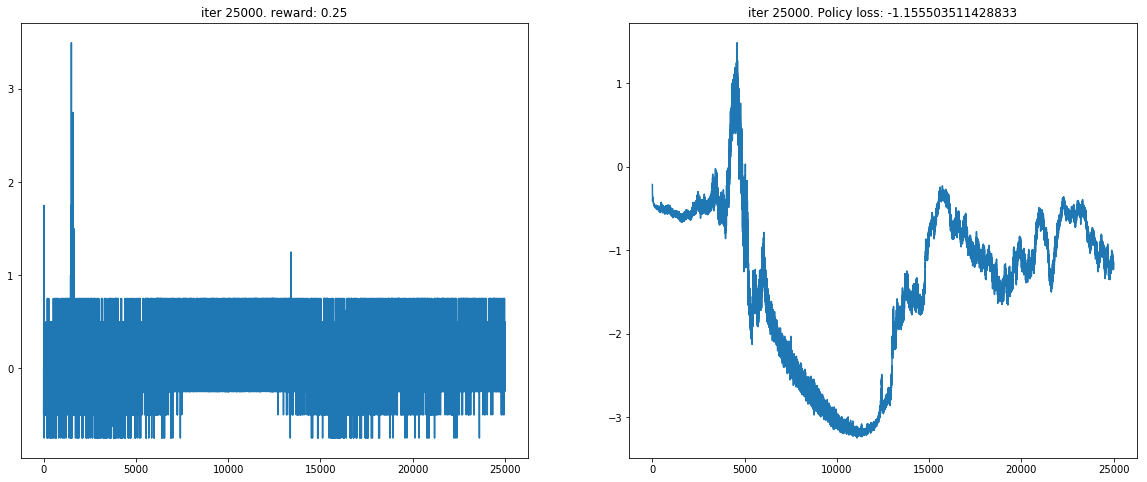

In [18]:
data = pd.read_csv('SOBI.csv')

BUY = 0
SELL = 1
HOLD = 2
ACTIONS = [BUY, SELL, HOLD]

inventory = 0
buyprice = 0
sellprice = 0

max_iteration = 25000
rewards=[]
iteration = 0
reward = 0

while iteration < max_iteration:
    
    episode_reward = scenario(policy_net, data) # generating & saving one scenario and return reward

    # Training
    if len(replay_buffer) > batch_size: # batch_size
        loss_list = soft_q_update(batch_size, alpha=0.25)
        for i, (key, value) in enumerate(losses.items()):
            losses[key].append(loss_list[i])

    rewards.append(episode_reward)
    iteration += 1
    
    if iteration % 500 == 0:
        plot(iteration, losses, rewards)
    

## Trading simulation

In [33]:
def simulation(policy_net, n):

    policy_net.eval()
    
    start = np.random.randint(low=1, high=1000) # arbitrary start point for iterative training
    step = np.random.randint(low=100, high=500) # arbitrary step, because delta t(Tick) is very small
    
    total_profits = []
    for i in range(n):
        inventory = 0
        buyprice = 0
        sellprice = 0
        reward = 0.
        
        profits=[]
        #for t in range(start, len(data), step):
        for t in range(0, len(data)):
            spread = data['dPrice'][t]
            state = [spread, inventory]
            action = getaction(policy_net, state, mode='eval')

            if inventory > 0.0:
                if action == SELL:
                    inventory = 0
                    # Originally selling can be done in ask price
                    # however, we assume that we can sell at mid-price in order to check the effect of SOBI starategy 
                    sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    reward += sellprice - buyprice
                    profits.append(reward)

            elif inventory < 0.0:
                if action == BUY:
                    inventory = 0
                    buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    reward += sellprice - buyprice
                    profits.append(reward)

            else:
                if action == BUY:
                    inventory += 1
                    buyprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    profits.append(None)

                elif action == SELL:
                    inventory -= 1
                    sellprice = (data['bidprc'][t] + data['askprc'][t]) / 2
                    profits.append(None)
        
        total_profits.append(profits)
        print('Simulation %.f is completed' % (i+1))
        
    return total_profits


## Result

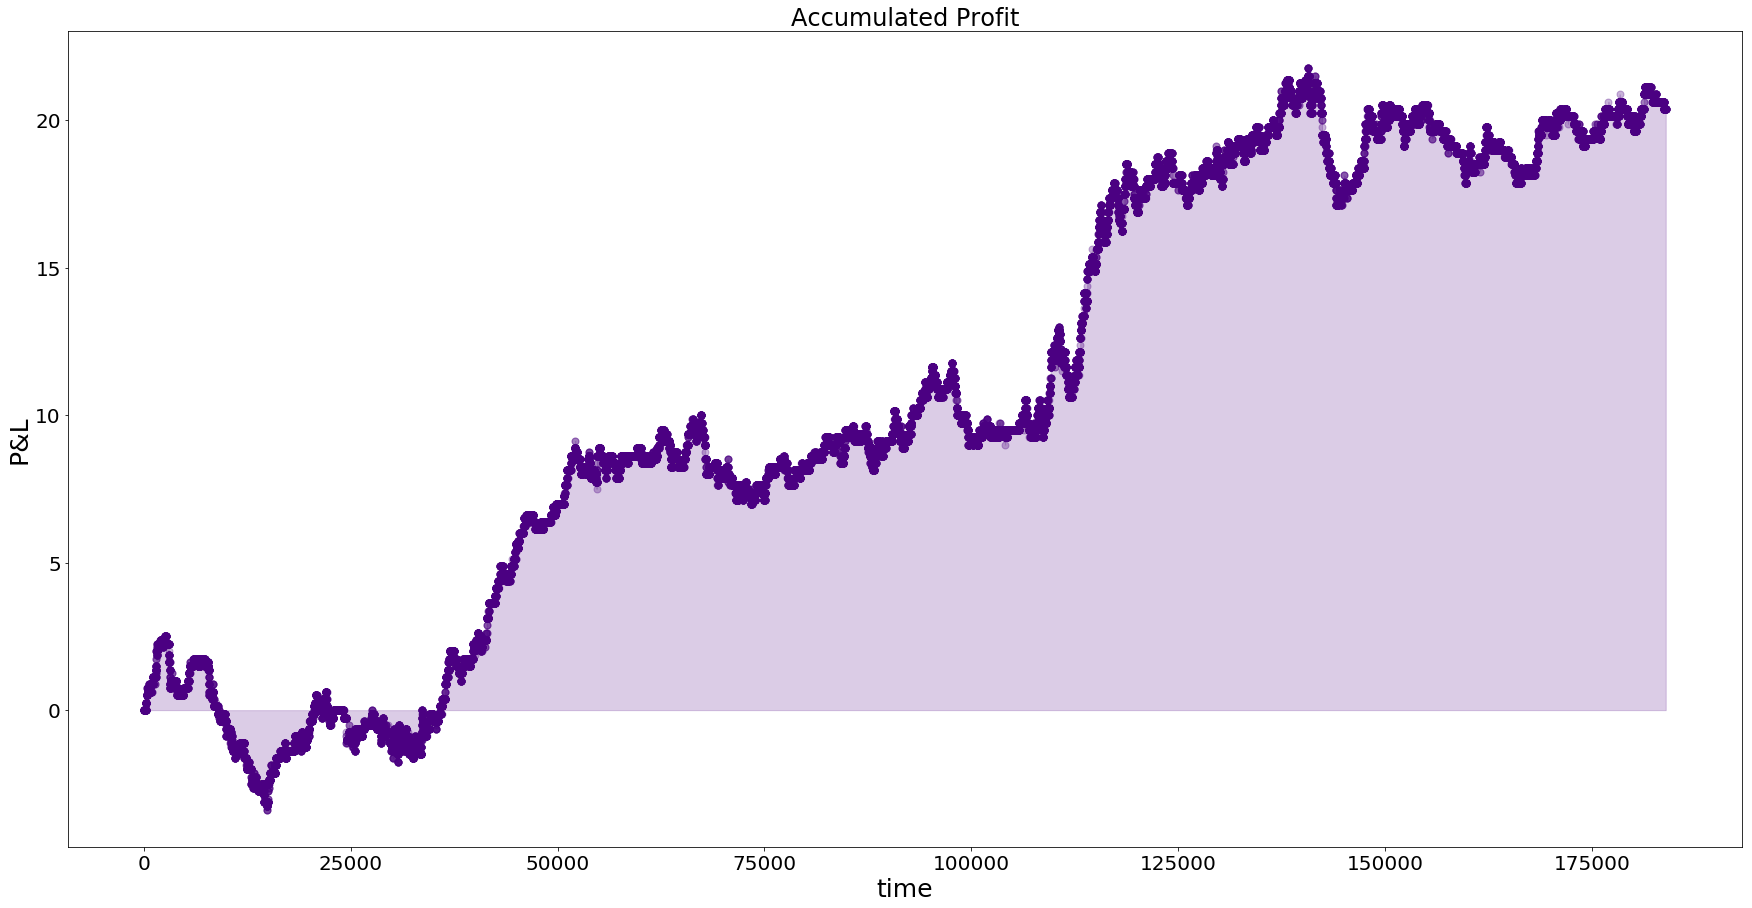

In [49]:
# Check the accumulated profit

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 20})
plt.rc('axes', labelsize = 25)
plt.rc('figure', titlesize = 30)

plt.xlabel('time')
plt.ylabel('P&L')
plt.plot(np.arange(len(total_profits[0])) ,total_profits[0], alpha=0.3, color='indigo', marker='o', markersize = 7)

plt.fill_between(np.arange(len(total_profits[0])) ,pd.Series(total_profits[0]).fillna(method='ffill').values,
                  alpha=0.2, color='indigo')
plt.title('Accumulated Profit')
plt.show()